Brakes analysis and tools to compute some more interesting data from the basic on/off provided by FastF1

In [1]:
import fastf1
import pandas as pd
import numpy as np
from pathlib import Path    
import matplotlib.pyplot as plt

*The computing is composed of different steps:*
1) Use fastf1.api.position_data(Session.api_path) or the Session methods to obtain the position dataframe for each driver. 



2) Take the lap car_data/telemetry (the one you already use) and interpolate (resample) the two streams on a common basis (e.g., Date index with 100 Hz frequency or using merge_asof on Date). The 2 samples rates are different (position ~ 220ms, telemetry ~ 240ms)

3) Calculate heading/curvature from X,Y (convert values from 1/10 m → m), then a_lat = v^2 * kappa (v in m/s).

4) Use a_lat to mark in_curve and cross with brake_proxy to calculate trail_brake_ratio.



Let's create some helper functions (curvature etc.)

In [2]:
def compute_heading(x, y):
    dx = np.gradient(x)
    dy = np.gradient(y)
    return np.arctan2(dy, dx)

def wrap_to_pi(ang):
    return (ang + np.pi) % (2*np.pi) - np.pi

def curvature_from_xy(x, y, distance=None):
    heading = compute_heading(x, y)
    if distance is None:
        dx = np.gradient(x)
        dy = np.gradient(y)
        ds = np.sqrt(dx*dx + dy*dy)
        s = np.cumsum(np.nan_to_num(ds))
    else:
        s = distance
    dtheta = wrap_to_pi(np.gradient(heading))
    ds = np.gradient(s)
    with np.errstate(divide='ignore', invalid='ignore'):
        kappa = np.nan_to_num(dtheta / ds)
    return kappa

In [3]:
session = fastf1.get_session(2024, 'Suzuka', 'R')
session.load()

req         WARNING 	DEFAULT CACHE ENABLED! (553.35 MB) C:\Users\fraba\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for lap_count. Loading data...
_api           INFO 	Fetching lap count data...
req            INFO 	Data has been written to cache!
req            INFO 	No cached data found for track_status_data. Loading data...
_api           INFO 	Fetching tr

In [4]:
#choosing a driver and its fastest lap
driver = 'VER'
lap = session.laps.pick_driver(driver).pick_fastest()
tel = lap.get_telemetry().reset_index(drop=True)

c:\Users\fraba\Desktop\racing-analysis\.venv\Lib\site-packages\fastf1\core.py:3183: FutureWarning: pick_driver is deprecated and will be removed in a future release. Use pick_drivers instead.
  warnings.warn(("pick_driver is deprecated and will be removed"


In [6]:
def find_best_pos_key(session, lap):
    """
    Cerca la chiave di session.pos_data che ha la massima sovrapposizione temporale
    con la telemetry del lap. Restituisce la key (o None).
    """
    pdict = getattr(session, "pos_data", None)
    if pdict is None:
        return None

    tel = lap.get_car_data().add_distance().reset_index(drop=True)
    try:
        tel_min = pd.to_datetime(tel['Date'].min())
        tel_max = pd.to_datetime(tel['Date'].max())
    except Exception:
        # fallback: se non ci sono Date, non possiamo usare overlap
        return None

    best = []
    for k in pdict.keys():
        dfk = pdict.get(k)
        if dfk is None or len(dfk) == 0:
            continue
        # normalize dfk Date
        if 'Date' in dfk.columns:
            try:
                dmin = pd.to_datetime(dfk['Date'].min())
                dmax = pd.to_datetime(dfk['Date'].max())
            except Exception:
                continue
        else:
            continue
        overlap_start = max(tel_min, dmin)
        overlap_end = min(tel_max, dmax)
        overlap_seconds = (overlap_end - overlap_start).total_seconds() if overlap_end > overlap_start else 0.0
        best.append((k, len(dfk), dmin, dmax, overlap_seconds))

    if not best:
        return None
    best_sorted = sorted(best, key=lambda x: x[4], reverse=True)
    # return the key with max overlap (could be 0; caller should check)
    return best_sorted[0][0]

In [7]:
def merge_pos_and_compute_lat(session, lap, tolerance_ms=600, max_jump_m=30.0,
                              lat_thresh=1.4, save_csv=True, out_folder=Path("data"),
                              return_all=False):
    """
    Merge robusto tra telemetry (lap) e position_data; calcola curvatura e lat_acc estimate.
    - session: fastf1 session object (should be loaded)
    - lap: a single lap row (from session.laps.pick_driver(...).pick_fastest() or similar)
    - tolerance_ms: tolerance per merge_asof (in milliseconds)
    - max_jump_m: filtro spaziale per rimuovere outlier in pos_df
    - lat_thresh: soglia (m/s^2) per flaggare 'in_curve'
    - save_csv: salva CSV in out_folder se True
    - return_all: se True ritorna anche pos_df e candidates per diagnostica
    Ritorna: merged DataFrame (e opzionalmente pos_df, best_key)
    """
    pdict = getattr(session, "pos_data", None)
    if pdict is None:
        raise RuntimeError("session.pos_data not available (no position data present)")

    # find best key via overlap
    best_key = find_best_pos_key(session, lap)
    if best_key is None:
        raise RuntimeError("No suitable pos_data key found for this lap (no overlap or missing Date).")

    pos_df = pdict.get(best_key)
    if pos_df is None or len(pos_df) == 0:
        raise RuntimeError(f"pos_data key {best_key} returned no rows.")

    pos_df = pos_df.copy()

    # Convert X,Y,Z units if present (FastF1 uses 1/10 m in many versions)
    if {'X','Y','Z'}.issubset(pos_df.columns):
        pos_df[['X','Y','Z']] = pos_df[['X','Y','Z']].astype(float) / 10.0

    # Normalize Date column in pos_df
    if 'Date' in pos_df.columns:
        pos_df['Date'] = pd.to_datetime(pos_df['Date'], errors='coerce')
    elif 'Time' in pos_df.columns:
        try:
            pos_df['Date'] = pd.to_datetime(pos_df['Time'])
        except Exception:
            pos_df['Date'] = pd.to_datetime(pos_df['Time'], unit='s', errors='coerce')
    pos_df = pos_df.dropna(subset=['Date']).sort_values('Date').drop_duplicates(subset='Date').reset_index(drop=True)

    # Prepare telemetry tel
    tel = lap.get_car_data().add_distance().reset_index(drop=True)
    if 'Date' in tel.columns:
        tel['Date'] = pd.to_datetime(tel['Date'], errors='coerce')
    else:
        # fallback: if Time present
        if 'Time' in tel.columns:
            tel['Date'] = pd.to_datetime(tel['Time'], errors='coerce')
        else:
            # try index -> seconds since epoch (rare)
            tel['Date'] = pd.to_datetime(tel.index, unit='s', errors='coerce')
    tel = tel.dropna(subset=['Date']).sort_values('Date').reset_index(drop=True)

    # quick spatial sanity filter: remove huge position jumps
    if 'X' in pos_df.columns and 'Y' in pos_df.columns:
        dx = np.diff(pos_df['X'].to_numpy(), prepend=pos_df['X'].to_numpy()[0])
        dy = np.diff(pos_df['Y'].to_numpy(), prepend=pos_df['Y'].to_numpy()[0])
        dd = np.sqrt(dx*dx + dy*dy)
        pos_df['delta_pos'] = dd
        pos_df = pos_df.loc[pos_df['delta_pos'] < max_jump_m].reset_index(drop=True)

    # merge_asof with tolerance
    merged = pd.merge_asof(tel, pos_df[['Date','X','Y','Z']], on='Date', direction='nearest',
                           tolerance=pd.Timedelta(f"{int(tolerance_ms)}ms"))
    # count NaNs for diagnostics
    nan_count = merged[['X','Y']].isna().any(axis=1).sum()

    # drop rows without position
    merged = merged.dropna(subset=['X','Y']).reset_index(drop=True)
    if len(merged) == 0:
        raise RuntimeError(f"Merged dataframe empty. Try increasing tolerance_ms or check timestamps. Nan rows before drop: {nan_count}")

    # compute s (cum distance) from X,Y
    x = merged['X'].to_numpy(dtype=float)
    y = merged['Y'].to_numpy(dtype=float)
    dx = np.gradient(x)
    dy = np.gradient(y)
    ds = np.sqrt(dx*dx + dy*dy)
    s = np.cumsum(np.nan_to_num(ds))
    merged['s_m'] = s

    # curvature and lateral acceleration estimate
    kappa = curvature_from_xy(x, y, distance=s)
    merged['kappa'] = kappa
    merged['v_ms'] = merged['Speed'].astype(float) / 3.6
    merged['lat_acc_est'] = (merged['v_ms']**2) * np.abs(merged['kappa'])

    # smoothing and in_curve flag
    merged['lat_acc_smooth'] = pd.Series(merged['lat_acc_est']).rolling(window=7, min_periods=1, center=True).median()
    merged['in_curve_est'] = (merged['lat_acc_smooth'] >= float(lat_thresh)).astype(int)

    # save CSV
    if save_csv:
        out_folder = Path(out_folder)
        out_folder.mkdir(parents=True, exist_ok=True)
        out_path = out_folder / f"pos_merged_driver{best_key}_lap{int(lap['LapNumber'])}.csv"
        merged.to_csv(out_path, index=False)

    if return_all:
        return merged, pos_df, best_key, nan_count
    return merged



In [8]:
merged = merge_pos_and_compute_lat(session, lap, tolerance_ms=600, max_jump_m=30.0, lat_thresh=1.4)
display(merged.head())
display(merged.tail())

,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance,X,Y,Z,s_m,kappa,v_ms,lat_acc_est,lat_acc_smooth,in_curve_est
0,2024-04-07 06:51:47.546,11013.0,281.0,7,100.0,False,12,car,0 days 00:00:00.392000,0 days 02:50:45.912000,30.597778,188.4,-105.7,73.5,18.885444,0.000449,78.055556,2.738400,1.471789,1
1,2024-04-07 06:51:47.706,11264.0,284.0,7,100.0,False,12,car,0 days 00:00:00.552000,0 days 02:50:46.072000,43.220000,200.5,-120.2,73.0,39.493998,0.000410,78.888889,2.551376,0.392202,0
2,2024-04-07 06:51:48.186,11528.0,289.0,7,100.0,False,12,car,0 days 00:00:01.032000,0 days 02:50:46.552000,81.753333,215.1,-137.1,72.3,57.114228,0.000061,80.277778,0.392202,1.072435,0
3,2024-04-07 06:51:48.385,11529.0,291.0,7,100.0,False,12,car,0 days 00:00:01.231000,0 days 02:50:46.751000,97.839167,223.5,-146.9,72.0,91.335018,-0.000010,80.833333,0.066949,0.392202,0
4,2024-04-07 06:51:48.785,11438.0,294.0,7,100.0,False,12,car,0 days 00:00:01.631000,0 days 02:50:47.151000,130.505833,259.6,-189.1,70.4,129.059281,0.000005,81.666667,0.035834,0.392202,0


,Date,RPM,Speed,nGear,Throttle,Brake,DRS,Source,Time,SessionTime,Distance,X,Y,Z,s_m,kappa,v_ms,lat_acc_est,lat_acc_smooth,in_curve_est
341,2024-04-07 06:53:19.466,10994.0,246.0,6,100.0,False,0,car,0 days 00:01:32.312000,0 days 02:52:17.832000,5666.193333,98.5,-5.4,77.5,5639.996119,-0.004446,68.333333,20.760074,14.738948,1
342,2024-04-07 06:53:19.746,11268.0,251.0,6,100.0,False,0,car,0 days 00:01:32.592000,0 days 02:52:18.112000,5685.715556,118.3,-24.8,76.7,5662.306038,-0.001608,69.722222,7.815159,7.815159,1
343,2024-04-07 06:53:20.186,11526.0,256.0,6,100.0,False,0,car,0 days 00:01:33.032000,0 days 02:52:18.552000,5717.004444,129.8,-37.2,76.1,5685.048180,-0.001532,71.111111,7.747162,7.781160,1
344,2024-04-07 06:53:20.466,11717.0,261.0,6,100.0,False,0,car,0 days 00:01:33.312000,0 days 02:52:18.832000,5737.304444,148.4,-58.9,75.3,5708.455016,-0.000464,72.500000,2.437017,7.747162,1
345,2024-04-07 06:53:20.706,10518.0,265.0,7,100.0,False,0,car,0 days 00:01:33.552000,0 days 02:52:19.072000,5754.971111,160.2,-72.8,74.7,5726.688228,-0.000159,73.611111,0.863456,5.092090,1


In [9]:
print("lat_acc_smooth: min, 25%, median, 75%, max:",
      np.nanmin(merged['lat_acc_smooth']), 
      np.nanpercentile(merged['lat_acc_smooth'],25),
      np.nanpercentile(merged['lat_acc_smooth'],50),
      np.nanpercentile(merged['lat_acc_smooth'],75),
      np.nanmax(merged['lat_acc_smooth']))

lat_acc_smooth: min, 25%, median, 75%, max: 0.12448584803605389 4.436719021672902 15.995047278434292 25.76479408764209 91.68541737936309


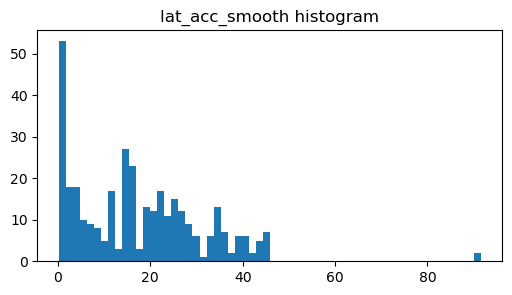

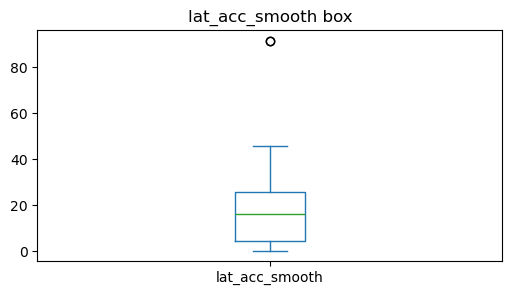

In [18]:
plt.figure(figsize=(6,3)); plt.hist(merged['lat_acc_smooth'].dropna(), bins=60); plt.title('lat_acc_smooth histogram'); plt.show()
plt.figure(figsize=(6,3)); merged['lat_acc_smooth'].plot.box(); plt.title('lat_acc_smooth box'); plt.show()

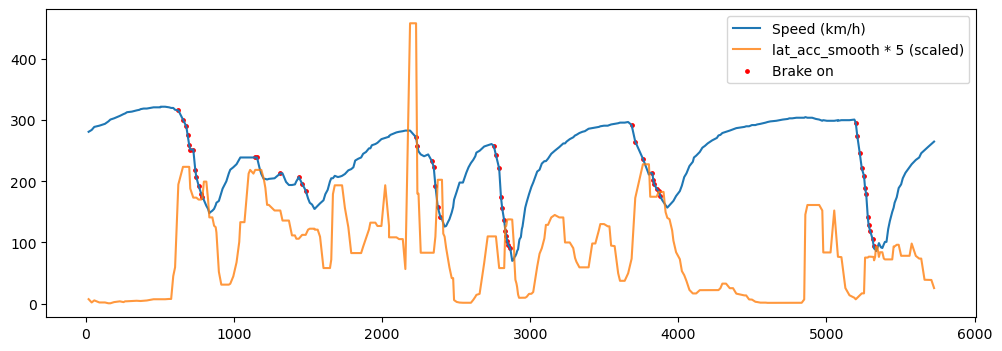

In [19]:
plt.figure(figsize=(12,4))
plt.plot(merged['s_m'], merged['Speed'], label='Speed (km/h)')
plt.plot(merged['s_m'], merged['lat_acc_smooth']*5, label='lat_acc_smooth * 5 (scaled)', alpha=0.8)  # scale for visibility
if 'Brake' in merged.columns:
    plt.scatter(merged['s_m'][merged['Brake']==1], merged['Speed'][merged['Brake']==1], c='red', s=6, label='Brake on')
plt.legend(); plt.show()

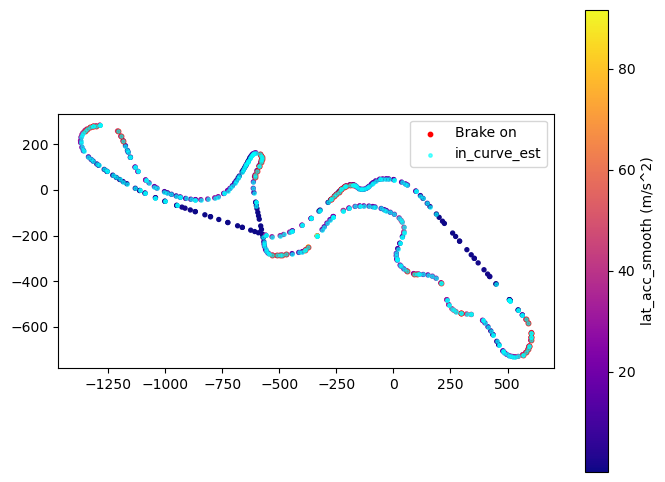

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(merged['X'], merged['Y'], c=merged['lat_acc_smooth'], s=8, cmap='plasma')
plt.colorbar(label='lat_acc_smooth (m/s^2)')
plt.scatter(merged['X'][merged['Brake']==1], merged['Y'][merged['Brake']==1], c='red', s=10, label='Brake on')
plt.scatter(merged['X'][merged['in_curve_est']==1], merged['Y'][merged['in_curve_est']==1], c='cyan', s=6, alpha=0.6, label='in_curve_est')
plt.legend(); plt.gca().set_aspect('equal','box'); plt.show()


In [24]:
pct_high = (merged['lat_acc_smooth']>8).mean()
pct_high

np.float64(0.6763005780346821)

In [26]:
merged['decel'] = -(merged['Speed'].astype(float)/3.6).diff() / merged['Date'].diff().dt.total_seconds()
corr = merged['Brake'].corr(merged['decel'].abs())
corr

np.float64(0.5731952616882308)

In [27]:
def lap_diagnostics(merged):
    import numpy as np
    out = {}
    out['n_samples'] = len(merged)
    out['coverage'] = 1.0  # if merged was saved after dropna
    out['lat_med'] = float(np.nanmedian(merged['lat_acc_smooth']))
    out['lat_max'] = float(np.nanmax(merged['lat_acc_smooth']))
    out['pct_high_lat'] = float((merged['lat_acc_smooth']>8).mean())
    if 'Brake' in merged.columns:
        out['brake_decel_corr'] = float(merged['Brake'].corr(merged['Speed'].diff().abs()))
    return out
# usage
print(lap_diagnostics(merged))

{'n_samples': 346, 'coverage': 1.0, 'lat_med': 15.995047278434292, 'lat_max': 91.68541737936309, 'pct_high_lat': 0.6763005780346821, 'brake_decel_corr': 0.5268652838357362}
